<a href="https://colab.research.google.com/github/lomovtsevp/diploma-real-time-emotions-recognition/blob/main/DIPLOMA_FACE_EMOTIONS_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the Pytorch implementation for fer-2013.
Salient features inlcudes:-
1. Albumentions data Augmentation
2. One Cycle Policy
Achived nearly 68.8 % Accuracy on test dataset

In [1]:
! pip install albumentations==0.4.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 8.0 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=225561ee32ce2528be207a9c7aa6b436d2e8841613ef11c862863a1e13958ae4
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [2]:
import torch
from torch.utils import data
import pandas as pd
import albumentations
from albumentations import pytorch as AT
from tqdm import tqdm
import math
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline 
import torch.nn.functional as F
import torchvision.models as models
from torch import nn
#from torchsummary import summary
from collections import OrderedDict
import torch.optim as optim

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
df=pd.read_csv('https://vk.com/doc296252774_643448616?hash=TpIKEuEC3ZdxKzqqUejXFzhSUJ9U26wI2OQvLWeT2uL&dl=0S5aHfbhBFP6ZfIhPC41y6qDIw0vBKJa2H0BkZXdChT')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [6]:
print(len(df[df['Usage']=='Training']))
print(len(df[df['Usage']=='PublicTest']))
print(len(df[df['Usage']=='PrivateTest']))

28709
3589
3589


**Converting pixes values to int**

In [7]:
df['pixelss']=[[int(y) for y in x.split()] for x in df['pixels']]

In [8]:
df.head()

,emotion,pixels,Usage,pixelss
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ..."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2..."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23..."


In [9]:
df_train=df[df['Usage']=='Training']
df_valid=df[df['Usage']=='PrivateTest']
df_test=df[df['Usage']=='PublicTest']

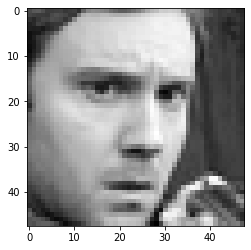

In [10]:
z=np.array(df_train['pixelss'][0])
zz=z.reshape(48,48)
plt.imshow(zz, interpolation='nearest',cmap='gray')
plt.show()

In [11]:
part={}
part['train']= list(range(0,len(df_train)))
part['valid']= list(range(0,len(df_valid)))
part['test']= list(range(0,len(df_test)))
train_labels=df_train['emotion'].tolist()
valid_labels=df_valid['emotion'].tolist()
test_labels=df_test['emotion'].tolist()

In [12]:
class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff=dff

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixelss']
        X = np.array(X).reshape(48,48,1)
        y = self.dff.iloc[index]['emotion']

        if self.transforms:
          X = self.transforms(X)
        
        X = torch.cat((X,X,X),0)

        return X, y

In [13]:
params = {'batch_size': 64,'shuffle': True,'num_workers': 10}

In [14]:
class AlbumentationWrapper(object):
    def __init__(self,split):
        self.split=split
        self.aug=albumentations.Compose([                                         
    albumentations.Normalize((0.5), (0.5)),
    AT.ToTensor()
    ])
	
        if self.split=='train':
            self.aug=albumentations.Compose([
                                             
            #albumentations.Resize(48,48),
    albumentations.HorizontalFlip(),
    albumentations.Cutout(2,2,2,0.5),
    albumentations.GaussNoise(),
    #albumentations.ElasticTransform(),    
    albumentations.Normalize((0.5), (0.5)),
    AT.ToTensor()    
    ])
            
    def __call__(self,img):
        #img = np.array(img)
        img = self.aug(image=img)['image']
        return img

In [15]:
train_transforms , validation_transforms=AlbumentationWrapper('train'), AlbumentationWrapper('test')

**Loading datasets**

In [16]:
training_set = Dataset(df_train, train_transforms)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(df_valid, validation_transforms)
validation_generator = data.DataLoader(validation_set, **params)

test_set = Dataset(df_test, validation_transforms)
test_generator = data.DataLoader(test_set, **params)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**function for plotting the test accuracy and loss curve**

In [17]:
def plot(train_losses,train_acc,test_losses,test_acc, label):
  fig, axs = plt.subplots(1,2,figsize=(20,8))
  axs[0].plot(test_losses, label=label)
  axs[0].set_title("Test Loss")
  axs[1].plot(test_acc, label=label)
  axs[1].set_title("Test Accuracy")

**Function for getting Learning rate at runtime**

In [18]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

**Model Trainning Code**

In [19]:
def train(model, train_loader, optimizer,scheduler):
  model.train()
  pbar = tqdm(train_loader)
  running_loss = 0.0
  correct = 0
  processed = 0
  criterion = nn.CrossEntropyLoss()

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = criterion(y_pred, target)
    running_loss += loss.item()
    train_loss.append(loss)
    loss.backward()
    optimizer.step()
    scheduler.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    #pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f} running_loss={running_loss} threshold={best_loss*(0.996)}')
    train_acc.append(100*correct/processed)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} le={get_lr(optimizer)} Accuracy={100*correct/processed:0.2f}')

**Model Test Code**

In [20]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            new_target=target.view_as(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    valid_loss.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    valid_acc.append(100. * correct / len(test_loader.dataset))

**Custom Model**

In [21]:
class Net(nn.Module):
    def __init__(self, dropout):
        super(Net, self).__init__()
        dropout_value = dropout
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # nn.Dropout(dropout_value)
        ) 

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            # nn.Dropout(dropout_value)            
        ) 

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 24 RF=7
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            # nn.Dropout(dropout_value)            
        ) 

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        ) 

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1, 1), padding=1 , bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            # nn.Dropout(dropout_value)            
        ) 

        # TRANSITION BLOCK 2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 12 RF=20

        # CONVOLUTION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)            
        ) 

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(1024),
            # nn.Dropout(dropout_value)            
        )

        # TRANSITION BLOCK 3
        self.pool3 = nn.MaxPool2d(2, 2) # output_size =6 RF=32

        self.convblock8 = nn.Sequential(
             nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=(3, 3), padding=1, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(512),
             # nn.Dropout(dropout_value)            
         ) 

        self.convblock9 = nn.Sequential(
             nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=0, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(256),
             # nn.Dropout(dropout_value)            
         )
        # self.pool2 = nn.MaxPool2d(2, 2) # output_size = 2
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) 
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=7, kernel_size=(1, 1), padding=0, bias=False)
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)        
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool3(x)   
        x = self.convblock8(x) 
        x = self.convblock9(x)    
        x = self.gap(x)
        x = self.convblock10(x)
        x = x.view(-1, 7)
        return F.log_softmax(x, dim=-1)

EPOCH: 0 LR: 0.0019999999999999983 


Loss=1.6359188556671143 Batch_id=448 le=0.0030634337130716477 Accuracy=29.26: 100%|██████████| 449/449 [01:21<00:00,  5.49it/s]



Test set: Average loss: 0.0284, Accuracy: 1397/3589 (38.92%)

EPOCH: 1 LR: 0.0030634337130716477 


Loss=1.7303553819656372 Batch_id=448 le=0.006002425682931637 Accuracy=36.61: 100%|██████████| 449/449 [01:15<00:00,  5.96it/s]



Test set: Average loss: 0.0246, Accuracy: 1650/3589 (45.97%)

EPOCH: 2 LR: 0.006002425682931637 


Loss=1.677746295928955 Batch_id=448 le=0.010122437433314183 Accuracy=37.95: 100%|██████████| 449/449 [01:15<00:00,  5.95it/s]



Test set: Average loss: 0.0205, Accuracy: 1876/3589 (52.27%)

EPOCH: 3 LR: 0.010122437433314183 


Loss=1.5305300951004028 Batch_id=448 le=0.014449833543417487 Accuracy=38.97: 100%|██████████| 449/449 [01:15<00:00,  5.95it/s]



Test set: Average loss: 0.0205, Accuracy: 1916/3589 (53.39%)

EPOCH: 4 LR: 0.014449833543417487 


Loss=1.6179111003875732 Batch_id=448 le=0.017961969810286214 Accuracy=40.23: 100%|██████████| 449/449 [01:15<00:00,  5.95it/s]



Test set: Average loss: 0.0181, Accuracy: 2064/3589 (57.51%)

EPOCH: 5 LR: 0.017961969810286214 


Loss=1.5032099485397339 Batch_id=448 le=0.019828863098122623 Accuracy=41.29: 100%|██████████| 449/449 [01:15<00:00,  5.98it/s]



Test set: Average loss: 0.0186, Accuracy: 1947/3589 (54.25%)

EPOCH: 6 LR: 0.019828863098122623 


Loss=1.4110599756240845 Batch_id=448 le=0.01997270340423158 Accuracy=42.00: 100%|██████████| 449/449 [01:15<00:00,  5.99it/s]



Test set: Average loss: 0.0175, Accuracy: 2099/3589 (58.48%)

EPOCH: 7 LR: 0.01997270340423158 


Loss=1.4113991260528564 Batch_id=448 le=0.01980732115328246 Accuracy=42.81: 100%|██████████| 449/449 [01:15<00:00,  5.97it/s]



Test set: Average loss: 0.0171, Accuracy: 2107/3589 (58.71%)

EPOCH: 8 LR: 0.01980732115328246 


Loss=1.5334622859954834 Batch_id=448 le=0.019494429167601215 Accuracy=43.78: 100%|██████████| 449/449 [01:15<00:00,  5.98it/s]



Test set: Average loss: 0.0177, Accuracy: 2138/3589 (59.57%)

EPOCH: 9 LR: 0.019494429167601215 


Loss=1.519789695739746 Batch_id=448 le=0.019038733633893166 Accuracy=44.23: 100%|██████████| 449/449 [01:15<00:00,  5.96it/s]



Test set: Average loss: 0.0167, Accuracy: 2157/3589 (60.10%)

EPOCH: 10 LR: 0.019038733633893166 


Loss=1.495168685913086 Batch_id=448 le=0.018447088637147856 Accuracy=44.79: 100%|██████████| 449/449 [01:14<00:00,  6.01it/s]



Test set: Average loss: 0.0160, Accuracy: 2250/3589 (62.69%)

EPOCH: 11 LR: 0.018447088637147856 


Loss=1.3027011156082153 Batch_id=448 le=0.017728393068821027 Accuracy=45.46: 100%|██████████| 449/449 [01:15<00:00,  5.97it/s]



Test set: Average loss: 0.0160, Accuracy: 2271/3589 (63.28%)

EPOCH: 12 LR: 0.017728393068821027 


Loss=1.5020182132720947 Batch_id=448 le=0.016893456779224002 Accuracy=45.66: 100%|██████████| 449/449 [01:14<00:00,  6.01it/s]



Test set: Average loss: 0.0158, Accuracy: 2271/3589 (63.28%)

EPOCH: 13 LR: 0.016893456779224002 


Loss=1.343371033668518 Batch_id=448 le=0.015954837987313175 Accuracy=46.65: 100%|██████████| 449/449 [01:14<00:00,  6.01it/s]



Test set: Average loss: 0.0153, Accuracy: 2298/3589 (64.03%)

EPOCH: 14 LR: 0.015954837987313175 


Loss=1.591343641281128 Batch_id=448 le=0.014926654393387674 Accuracy=47.06: 100%|██████████| 449/449 [01:14<00:00,  6.02it/s]



Test set: Average loss: 0.0155, Accuracy: 2275/3589 (63.39%)

EPOCH: 15 LR: 0.014926654393387674 


Loss=1.3312004804611206 Batch_id=448 le=0.013824370835736084 Accuracy=47.95: 100%|██████████| 449/449 [01:14<00:00,  6.03it/s]



Test set: Average loss: 0.0154, Accuracy: 2319/3589 (64.61%)

EPOCH: 16 LR: 0.013824370835736084 


Loss=1.4828685522079468 Batch_id=448 le=0.012664566685073859 Accuracy=48.02: 100%|██████████| 449/449 [01:14<00:00,  6.04it/s]



Test set: Average loss: 0.0155, Accuracy: 2339/3589 (65.17%)

EPOCH: 17 LR: 0.012664566685073859 


Loss=1.2564183473587036 Batch_id=448 le=0.011464686475375662 Accuracy=48.65: 100%|██████████| 449/449 [01:14<00:00,  6.02it/s]



Test set: Average loss: 0.0160, Accuracy: 2257/3589 (62.89%)

EPOCH: 18 LR: 0.011464686475375662 


Loss=1.5019505023956299 Batch_id=448 le=0.010242777521846942 Accuracy=50.21: 100%|██████████| 449/449 [01:14<00:00,  6.04it/s]



Test set: Average loss: 0.0158, Accuracy: 2349/3589 (65.45%)

EPOCH: 19 LR: 0.010242777521846942 


Loss=1.1385314464569092 Batch_id=448 le=0.009017218472504782 Accuracy=51.12: 100%|██████████| 449/449 [01:14<00:00,  6.02it/s]



Test set: Average loss: 0.0166, Accuracy: 2324/3589 (64.75%)

EPOCH: 20 LR: 0.009017218472504782 


Loss=1.3605756759643555 Batch_id=448 le=0.007806442876204813 Accuracy=52.26: 100%|██████████| 449/449 [01:14<00:00,  6.05it/s]



Test set: Average loss: 0.0159, Accuracy: 2351/3589 (65.51%)

EPOCH: 21 LR: 0.007806442876204813 


Loss=1.0050987005233765 Batch_id=448 le=0.006628661924908432 Accuracy=53.61: 100%|██████████| 449/449 [01:14<00:00,  6.04it/s]



Test set: Average loss: 0.0163, Accuracy: 2323/3589 (64.73%)

EPOCH: 22 LR: 0.006628661924908432 


Loss=1.1715754270553589 Batch_id=448 le=0.005501590540404688 Accuracy=54.19: 100%|██████████| 449/449 [01:14<00:00,  6.05it/s]



Test set: Average loss: 0.0162, Accuracy: 2368/3589 (65.98%)

EPOCH: 23 LR: 0.005501590540404688 


Loss=1.3611602783203125 Batch_id=448 le=0.004442180925397468 Accuracy=55.62: 100%|██████████| 449/449 [01:14<00:00,  6.04it/s]



Test set: Average loss: 0.0165, Accuracy: 2397/3589 (66.79%)

EPOCH: 24 LR: 0.004442180925397468 


Loss=0.9636533856391907 Batch_id=448 le=0.003466367586597686 Accuracy=57.63: 100%|██████████| 449/449 [01:14<00:00,  6.04it/s]



Test set: Average loss: 0.0167, Accuracy: 2413/3589 (67.23%)

EPOCH: 25 LR: 0.003466367586597686 


Loss=1.2642817497253418 Batch_id=448 le=0.0025888276649104597 Accuracy=58.94: 100%|██████████| 449/449 [01:14<00:00,  6.04it/s]



Test set: Average loss: 0.0167, Accuracy: 2398/3589 (66.82%)

EPOCH: 26 LR: 0.0025888276649104597 


Loss=0.9534886479377747 Batch_id=448 le=0.0018227601775743923 Accuracy=59.65: 100%|██████████| 449/449 [01:14<00:00,  6.04it/s]



Test set: Average loss: 0.0170, Accuracy: 2407/3589 (67.07%)

EPOCH: 27 LR: 0.0018227601775743923 


Loss=1.312956690788269 Batch_id=448 le=0.0011796874926566104 Accuracy=61.10: 100%|██████████| 449/449 [01:14<00:00,  6.01it/s]



Test set: Average loss: 0.0172, Accuracy: 2447/3589 (68.18%)

EPOCH: 28 LR: 0.0011796874926566104 


Loss=0.8478143215179443 Batch_id=448 le=0.0006692820219119917 Accuracy=61.24: 100%|██████████| 449/449 [01:14<00:00,  6.02it/s]



Test set: Average loss: 0.0168, Accuracy: 2467/3589 (68.74%)

EPOCH: 29 LR: 0.0006692820219119917 


Loss=0.7746143937110901 Batch_id=448 le=0.0002992207387072647 Accuracy=61.58: 100%|██████████| 449/449 [01:14<00:00,  6.03it/s]



Test set: Average loss: 0.0166, Accuracy: 2454/3589 (68.38%)

EPOCH: 30 LR: 0.0002992207387072647 


Loss=0.8084185123443604 Batch_id=448 le=7.506970919582438e-05 Accuracy=62.61: 100%|██████████| 449/449 [01:14<00:00,  6.04it/s]



Test set: Average loss: 0.0167, Accuracy: 2475/3589 (68.96%)

EPOCH: 31 LR: 7.506970919582438e-05 


Loss=0.9562544822692871 Batch_id=448 le=2.0037350187915896e-07 Accuracy=62.20: 100%|██████████| 449/449 [01:14<00:00,  6.04it/s]



Test set: Average loss: 0.0170, Accuracy: 2458/3589 (68.49%)



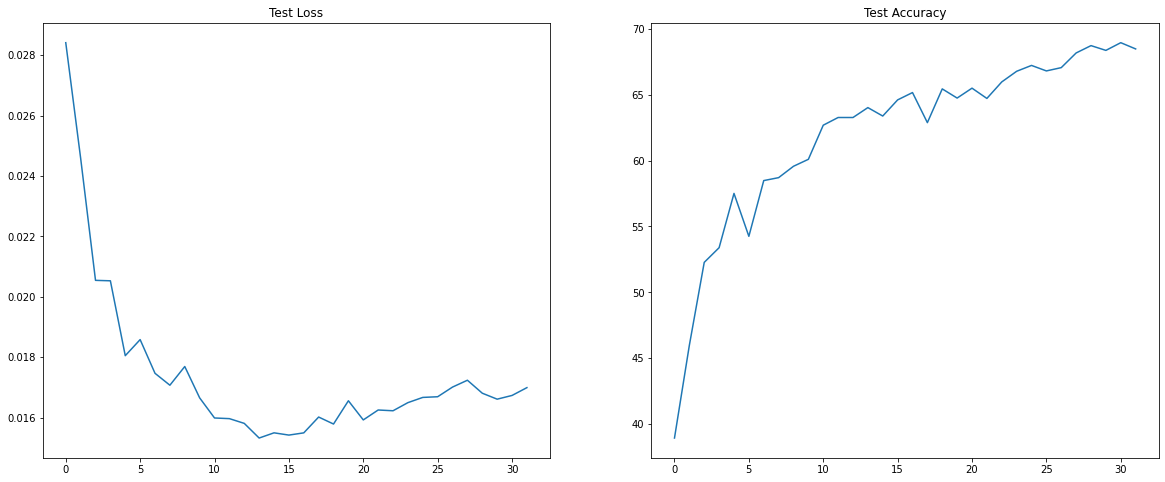

In [22]:
model=Net(1.0)
model.to(device)
epochs=32
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9, weight_decay=9e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02, steps_per_epoch=len(training_generator), pct_start=0.2, div_factor=10, cycle_momentum=False, epochs=epochs)

input_size=(3,48,48)
train_acc = []
train_loss = []
valid_acc = []
valid_loss = []
for epoch in range(epochs):
    print("EPOCH: %s LR: %s " % (epoch, get_lr(optimizer)))
    train(model, training_generator, optimizer,scheduler)
    test(model, validation_generator)
    #scheduler.step()
plot(train_loss,train_acc, valid_loss, valid_acc, 'Loss & Accuracy')

In [24]:
torch.save(model, 'FER2013_MODEL.pth')